In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)

#显示所有行

pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import datetime
import warnings
import feather
warnings.filterwarnings("ignore")
import math
sys.path.append('/data/apps/modules/jupyter')
from helper.spark_helper import *
from helper.presto_helper import query_presto
from helper.csv_helper import *
from helper.pandas_helper import *
from helper.presto_helper import query_hive_wy

# 抽取安卓用户，向极光查询数据

In [2]:
#citys = ','.join([str(i) for i in [196,155,231,132,357,83,377,179,269,87,153,247,295,373,320,332,376,227,223,195,404,503,471]])
citys= 196
features = get_df_from_csv_table(query_presto(f'''
    select a.user_id, a.city_id, a.birthday, a.mobile, a.gender, b.model, b.brand, b.sys_ver, b.active_days_180d, b.active_count_180d, b.last_active_time, a.first_order_time
    from
    (select user_id, city_id, birthday, gender, mobile, first_order_time
    from dim.dim_user_info_df
    where city_id in ({citys})
    and has_order=1
    and gender>0
    and birthday is not null
    and is_repeat_idcard = 0
    and event_day='20210328') a left join
    (select user_id, model, brand, sys_ver, active_days_180d, active_count_180d, last_active_time
    from dws.dws_pt_user_action_da
    where event_day='20210328') b on a.user_id=b.user_id
'''))

features = features.dropna()

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py", line 377, in _make_request
    httplib_response = conn.getresponse(buffering=True)
TypeError: getresponse() got an unexpected keyword argument 'buffering'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/helper/presto_helper.py", line 81, in execute
    query_result = list(cursor.fetchall())
  File "/usr/local/lib/python3.6/site-packages/prestodb/dbapi.py", line 292, in fetchall
    return list(self.genall())
  File "/usr/local/lib/python3.6/site-packages/prestodb/client.py", line 467, in __iter__
    rows = self._query.fetch()
  File "/usr/local/lib/python3.6/site-packages/prestodb/client.py", line 533, in fetch
    response = self._request.get(self._request.next_uri)
  File "/usr/local/lib/python3.6/site-packages/prestodb/client.py", line 373, in get
    proxies=PROXIES,
  F

TypeError: 'NoneType' object is not subscriptable

In [21]:
#features['sys_ver_edited'] = train_df.sys_ver.map(edit_ver)
import re
def clean_iOS(x):
    if re.match('\d+\..*', x):
        return 'Android'
    elif re.match('Android \d+\..*', x):
        return 'Android'
    elif re.match('Android \d+$', x):
        return 'Android'
    elif re.match('\d+$', x):
        return 'Android'
    else:
        return 'Other'
    
    
features['sys'] = features['sys_ver'].map(clean_iOS)
temp = features[(features.sys=='Android') & (features.active_days_180d>0)]
len(temp)

In [ ]:
final = pd.concat([temp[temp.gender==1].sample(10860), temp[temp.gender==2]])
final.to_csv('users_50000.csv')
with open('users_50000.txt','w') as f:
    f.write('\n'.join(final.mobile.map(lambda x: str(x)).tolist()))

# 用统计学方式生产第一批数据
### 从原始订单表里，根据user_id分组，每位用户取历史出行记录的中位数，算出了目标单量。相当于把历史上的流失用户全都召回了。

In [210]:
def app(x):
    rank = int(len(x.month_order)*0.5)-1
    if rank==-1: rank=0
    return sorted(x.month_order.tolist())[rank]
            
for c in [231,332,196,295,357,376,320,132,377]:
    temp = get_df_from_csv_table(query_presto(f'''
        select user_id, count(order_id) month_order
        from dwd.dwd_bd_order_detail_da
        where city_id = {c}
        group by date_format(start_time , '%x-%m'), user_id
    '''))    

    print(c, temp.groupby('user_id').apply(app).sum()*12)


231 7417008
332 4362336
196 4169532
295 3364116
357 3878532
376 6867564
320 8061708
132 6099312


# 特征处理及模型训练
### 可用数据：性别，年龄，设备信息（手机机型、操作系统），常驻城市

In [10]:
#citys = ','.join([str(i) for i in [196,155,231,132,357,83,377,179,269,87,153,247,295,373,320,332,376,227,223,195,404,503,471]])
citys='196'
features = get_df_from_csv_table(query_presto(f'''
    select a.user_id, a.city_id, a.birthday, a.gender, b.model, b.brand, b.sys_ver,a.mobile
    from
    (select user_id, city_id, birthday, gender, mobile
    from dim.dim_user_info_df
    where city_id in ({citys})
    and gender!=0
    and birthday is not null
    and event_day='20210328') a left join
    (select user_id, model, brand, sys_ver
    from dws.dws_pt_user_action_da
    where event_day='20210328') b on a.user_id=b.user_id
'''))



In [64]:
features=features.dropna()

In [148]:
get_df_from_csv_table(query_presto(f'''
    select count(distinct(user_id))
    from dwd.dwd_bd_order_detail_da
    where city_id=227
    and event_day>'20200521'
'''))

,_col0
0,129343


In [198]:
df2 = get_df_from_csv_table(query_presto(f'''
    select user_id, count(order_id) month_order
    from dwd.dwd_bd_order_detail_da
    where city_id = 227
    group by date_format(start_time , '%x-%m'), user_id
'''))

In [23]:
orders = get_df_from_csv_table(query_presto(f'''
    select user_id, cur_date, order_count_d, order_count_t
    from dws.dws_pt_user_picture_da
    where city_id in (196)
''')).dropna()

In [8]:
jiguang_df=pd.read_csv('iaudience.csv')

In [13]:
jiguang_df=jiguang_df.rename({'imei/phone/mac/imsi':'mobile'},axis=1)

In [14]:
jiguang_df.head()

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,CAR_Part_LocViewScore,CAR_Rental_LocViewDateScore,CAR_Rental_LocViewScore,CAR_Repair_LocViewDateScore,CAR_Repair_LocViewScore,CAR_Sale_LocViewDateScore,CAR_Sale_LocViewScore,CAR_Service_LocViewDateScore,CAR_Service_LocViewScore,ALL_Home_Work_LocDistanceScore,ALL_Trip_LocViewDateScore,ALL_Trip_LocViewScore,EDU_Driving_LocViewDateScore,EDU_Driving_LocViewScore,EDU_Child_LocViewDateScore,EDU_Child_LocViewScore,EDU_Kindergarden_LocViewDateScore,EDU_Kindergarden_LocViewScore,EDU_Primary_LocViewDateScore,EDU_Primary_LocViewScore,EDU_Junior_LocViewDateScore,EDU_Junior_LocViewScore,EDU_Middle_LocViewDateScore,EDU_Middle_LocViewScore,EDU_Senior_LocViewDateScore,EDU_Senior_LocViewScore,EDU_Colleage_LocViewDateScore,EDU_Colleage_LocViewScore,EDU_Abroad_LocViewDateScore,EDU_Abroad_LocViewScore,EDU_Adult_LocViewDateScore,EDU_Adult_LocViewScore,EDU_Art_LocViewDateScore,EDU_Art_LocViewScore,EDU_Body_Building_LocViewDateScore,EDU_Body_Building_LocViewScore,EDU_Gourmand_LocViewDateScore,EDU_Gourmand_LocViewScore,EDU_Language_LocViewDateScore,EDU_Language_LocViewScore,EDU_Officeholder_LocViewDateScore,EDU_Officeholder_LocViewScore,EDU_Postgraduate_LocViewDateScore,EDU_Postgraduate_LocViewScore,HOUSE_Newhouse_LocViewDateScore,HOUSE_Newhouse_LocViewScore,TRAVEL_Travel_Agency_LocViewDateScore,TRAVEL_Travel_Agency_LocViewScore,TRAVEL_Travel_LocViewDateScore,TRAVEL_Travel_LocViewScore
0,18282870056,查询标签成功-有标签,有,M,已婚,中国,1.0,未知,R9,OPPO,cpu数:八核;cpu型号:联发科 MT6755;cpu主频:2.0GHZ;ram:未知;手...,中国移动,Android,2499.0,1920*1080,5.5英寸,2016年05月,手机,NaN,中,低,N,"大众,1.0",企业人员,听音乐&1、工作一族&1、户外休闲&1、精打细算&1、购物狂&1,计算器&1、阅读器&1、麻将棋牌&3、日历闹钟天气&2、兴趣社区&1、wifi网络&2、聊天...,"团购,0.5&网络商城,0.5",其它、转账支付、学习辅导、聊天交友、健身攻略、购物、听音乐、考试资料、地图查询、休闲,健身攻略、搜索查询、外文阅读、体育新闻、论坛微博,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13568652678,查询标签成功-有标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,中国移动,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13861134574,查询标签成功-无标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13981566579,查询标签成功-有标签,有,F,已婚,中国,1.0,孕育期,X7 PLUS,VIVO,cpu数:八核;cpu型号:高通 骁龙652（MSM8976）;cpu主频:1.8GHZ;r...,中国电信,Android,1270.0,1920*1080,5.7英寸,2016年07月23日,手机,NaN,NaN,NaN,图书专卖,"大众,1.0",企业人员,听音乐&1、工作一族&2、潮范儿&2、爱美食&1、看视频&4、社交达人&2、精打细算&3、购...,生活小工具&3、拍照P图&8、小说阅读&1、视频播放&4、便签记事&1、综合商城&2、wif...,"购物分享,0.25&团购,0.25&网络商城,0.5",其它

In [65]:
features['mobile']=features['mobile'].astype('int')

In [67]:
merge_df=pd.merge(jiguang_df,features,on='mobile',how='left')

In [68]:
merge_df.shape

(30132, 347)

## label需要通过dwd.dwd_bd_order_detail_da来重新生产
### 对数据进行了简单检验，发现dws.dws_pt_user_picture_da里的count_d和实际值不吻合。具体还没评估。

In [142]:
get_df_from_csv_table(query_presto(f'''
    select count(order_id)
    from dwd.dwd_bd_order_detail_da
    where city_id=227
'''))

,_col0
0,6922355


In [139]:
get_df_from_csv_table(query_presto(f'''
    select sum(order_count_t)
    from dws.dws_pt_user_picture_da
    where city_id in (227)
    and event_day='20210328'
'''))

,_col0
0,6713799


In [143]:
get_df_from_csv_table(query_presto(f'''
    select count(order_id)
    from dwd.dwd_bd_order_detail_da
    where city_id=227 and event_day>'20200521'
'''))

,_col0
0,2574838


In [132]:
get_df_from_csv_table(query_presto(f'''
    select sum(order_count_d)
    from dws.dws_pt_user_picture_da
    where city_id in (227)
'''))

,_col0
0,969204


In [25]:
# orders = get_df_from_csv_table(query_presto(f'''
#     select user_id, cur_date, order_count_d, order_count_t
#     from dws.dws_pt_user_picture_da
#     where city_id in ({citys})
# ''')).dropna()

orders['cur_date'] = pd.to_datetime(orders['cur_date'])
orders['month'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).month
orders['year'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).year
orders['day'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).day
orders['week'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).week

In [29]:
temp = orders.groupby('user_id').agg({'order_count_d':'sum'})

In [30]:
temp = temp.reset_index()
train_list = temp[temp.order_count_d>0].user_id
test_list = temp[temp.order_count_d==0].user_id

In [26]:
# od: 每天订单最大值
od = orders.groupby(['user_id']).order_count_d.max().reset_index()
od = od[od.order_count_d>0]

In [27]:
# ow: 每周订单最大值
ow = orders.groupby(['user_id','week']).order_count_d.sum().reset_index()
ow = ow.groupby('user_id').order_count_d.max().reset_index()

In [28]:
# pref: 偏好
od['pref'] = 1* (od['order_count_d']>1)

In [49]:
od

,user_id,order_count_d,pref
0,913566,1.0,0
1,940475,2.0,1
2,948845,2.0,1
3,963646,3.0,1
10,1104327,2.0,1
11,1120280,1.0,0
14,1161974,3.0,1
15,1178752,1.0,0
17,1199696,1.0,0
19,1268960,2.0,1


In [91]:
train_df = pd.merge(merge_df,od[od.user_id.isin(train_list)], on='user_id', how='left')

In [92]:
import re
re.search('\d+','5.4.3')[0]
def edit_ver(x):
    try:
        if type(x)==type(0.1):
            return 'None'
        elif re.match('\d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+$', x):
            return x
        elif re.match('iOS \d+$', x):
            return x
        elif re.match('iOS\d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('iOS \d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('\d+$', x):
            return 'Android '+x
        else:
            return 'Other'
    except:
        print(type(x))

In [93]:
train_df.groupby('sys_ver').count().sort_values(by='brand',ascending=False)
train_df['sys_ver_edited'] = train_df.sys_ver.map(edit_ver)

In [63]:
# train_df=train_df.dropna(axis=0,how='any',subset=['birthday','sys_ver'])


TypeError: dropna() got an unexpected keyword argument "subset"

In [94]:
train_df['birthyear'] = train_df['birthday'].map(lambda x: int(x[:4]))

In [95]:
train_df=train_df.fillna('None')

In [ ]:
tmp_list=list(jiguang_df.columns)
tmp_list.remove('CPL_INDM_UNDERG')

In [96]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lis=['mobile']
for col in ['brand','sys_ver_edited']+tmp_list:
    try:
        train_df[col+'_transformed'] = lbl.fit_transform(train_df[col].astype('category'))
    except:
        lis.append(col)

# train =train[train.is_true_sample==1]

In [97]:
lis

['mobile', 'CPL_INDM_AGE_C5', 'CPL_DVM_PUPR']

In [111]:
train_df2 = pd.merge(train_df, ow.rename({'order_count_d':'week_max_order'}, axis=1), on='user_id')

In [122]:
train_df2['pref'] = 1*(train2['week_max_order']>1)

In [99]:
col_feat = ['gender', 'birthyear']
for col in list(train_df.columns):
    if len(col)<11 or col[:7]=='CPL_DVM' or col[:]=='CID_MODEL':
        continue
    if col[-11:]=='transformed':
        col_feat.append(col)
        


In [106]:
tmp_df=train_df[col_feat]
tmp_df.shape

(30132, 333)

In [112]:
tmp_df.columns[(tmp_df=='None').sum()==1]

Index([], dtype='object')

In [ ]:

for i in range(tmp_df.shape[0]):
    for j in range(tmp_df.shape[1]):
        if tmp_df[i][j]=="None":
            

In [116]:
train_df[col_ans].head()

0    1
1    1
2    1
3    1
4    1
Name: pref, dtype: object

In [120]:
train_df=train_df[train_df['pref']!='None']

### 至此，一共生产了train_df和train_df2两个dataframe，分别是按照日取偏好label和按照周取

In [139]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

temp = train_df


col_ans = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

# for train_index, test_index in kf.split(temp):
# f+=1
# train = temp.iloc[train_index]
# test = temp.iloc[test_index]

train_X,test_X,train_y,test_y =train_test_split(temp[col_feat],temp[col_ans],test_size=0.3)


params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
        'gamma': 0.1,
    'max_depth': 5,
        'lambda': 10,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'min_child_weight': 1,
    'eta': 0.01,
    'seed': 1000,
    'nthread': 4,
     'eval_metric':['auc','error'],
#     'alpha': 5
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 100
plst = params.items()
#model = XGBClassifier(params)
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])
#model.fit(X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(test[col_feat],test[col_ans])], verbose=True)
#pred = model.predict(test[col_feat])
#pred = [round(value) for value in pred]
#     accuracy = accuracy_score(test[col_ans], pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

[0]	eval-auc:0.52078	eval-error:0.31247	train-auc:0.53845	train-error:0.30759
[1]	eval-auc:0.51531	eval-error:0.30821	train-auc:0.55146	train-error:0.30983
[2]	eval-auc:0.51623	eval-error:0.30807	train-auc:0.55593	train-error:0.31024
[3]	eval-auc:0.51231	eval-error:0.30821	train-auc:0.57299	train-error:0.31007
[4]	eval-auc:0.51678	eval-error:0.30794	train-auc:0.57946	train-error:0.31013
[5]	eval-auc:0.52010	eval-error:0.30807	train-auc:0.58173	train-error:0.31007
[6]	eval-auc:0.51966	eval-error:0.30780	train-auc:0.58413	train-error:0.30989
[7]	eval-auc:0.52171	eval-error:0.30794	train-auc:0.58870	train-error:0.31019
[8]	eval-auc:0.52080	eval-error:0.30794	train-auc:0.59147	train-error:0.31019
[9]	eval-auc:0.52357	eval-error:0.30794	train-auc:0.59113	train-error:0.31019
[10]	eval-auc:0.52367	eval-error:0.30780	train-auc:0.59003	train-error:0.31019
[11]	eval-auc:0.52515	eval-error:0.30780	train-auc:0.59113	train-error:0.31019
[12]	eval-auc:0.52618	eval-error:0.30780	train-auc:0.59132	tra

In [136]:
temp['pref'].sum()/len(temp)

0.6904889622446875

In [125]:
import lightgbm as lgb

num_round = 100
temp = train_df
# col_feat = ['brand_transformed', 'sys_ver_edited_transformed', 'gender', 'birthyear']
col_ans = 'pref'


params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 50,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,	#提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1, #l1正则
          # 'lambda_l2': 0.001, #l2正则
          "verbosity": -1,
          "nthread": 3, #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'auc'}, #评价函数选择
          "random_state": 2019,	#随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

folds = KFold(n_splits=5, shuffle=True, random_state=2019)
# prob_oof = np.zeros((train_x.shape[0], ))
# test_pred_prob = np.zeros((test.shape[0], ))


## train and predict
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(temp)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(temp.iloc[trn_idx][col_feat], label=temp.iloc[trn_idx][col_ans])
    val_data = lgb.Dataset(temp.iloc[val_idx][col_feat], label=temp.iloc[val_idx][col_ans])


    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=5,
                    early_stopping_rounds=60)
    #prob_oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    #test_pred_prob += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

# threshold = 0.5
# for pred in test_pred_prob:
#     result = 1 if pred > threshold else 0
    
    

fold 1


ValueError: Series.dtypes must be int, float or bool

In [149]:
# fig=plt.figure(figsize=(4,3))
# plt.rcParams["figure.figsize"] = (14, 8)
# %matplotlib
plot_importance(model,importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<IPython.core.display.Javascript object>


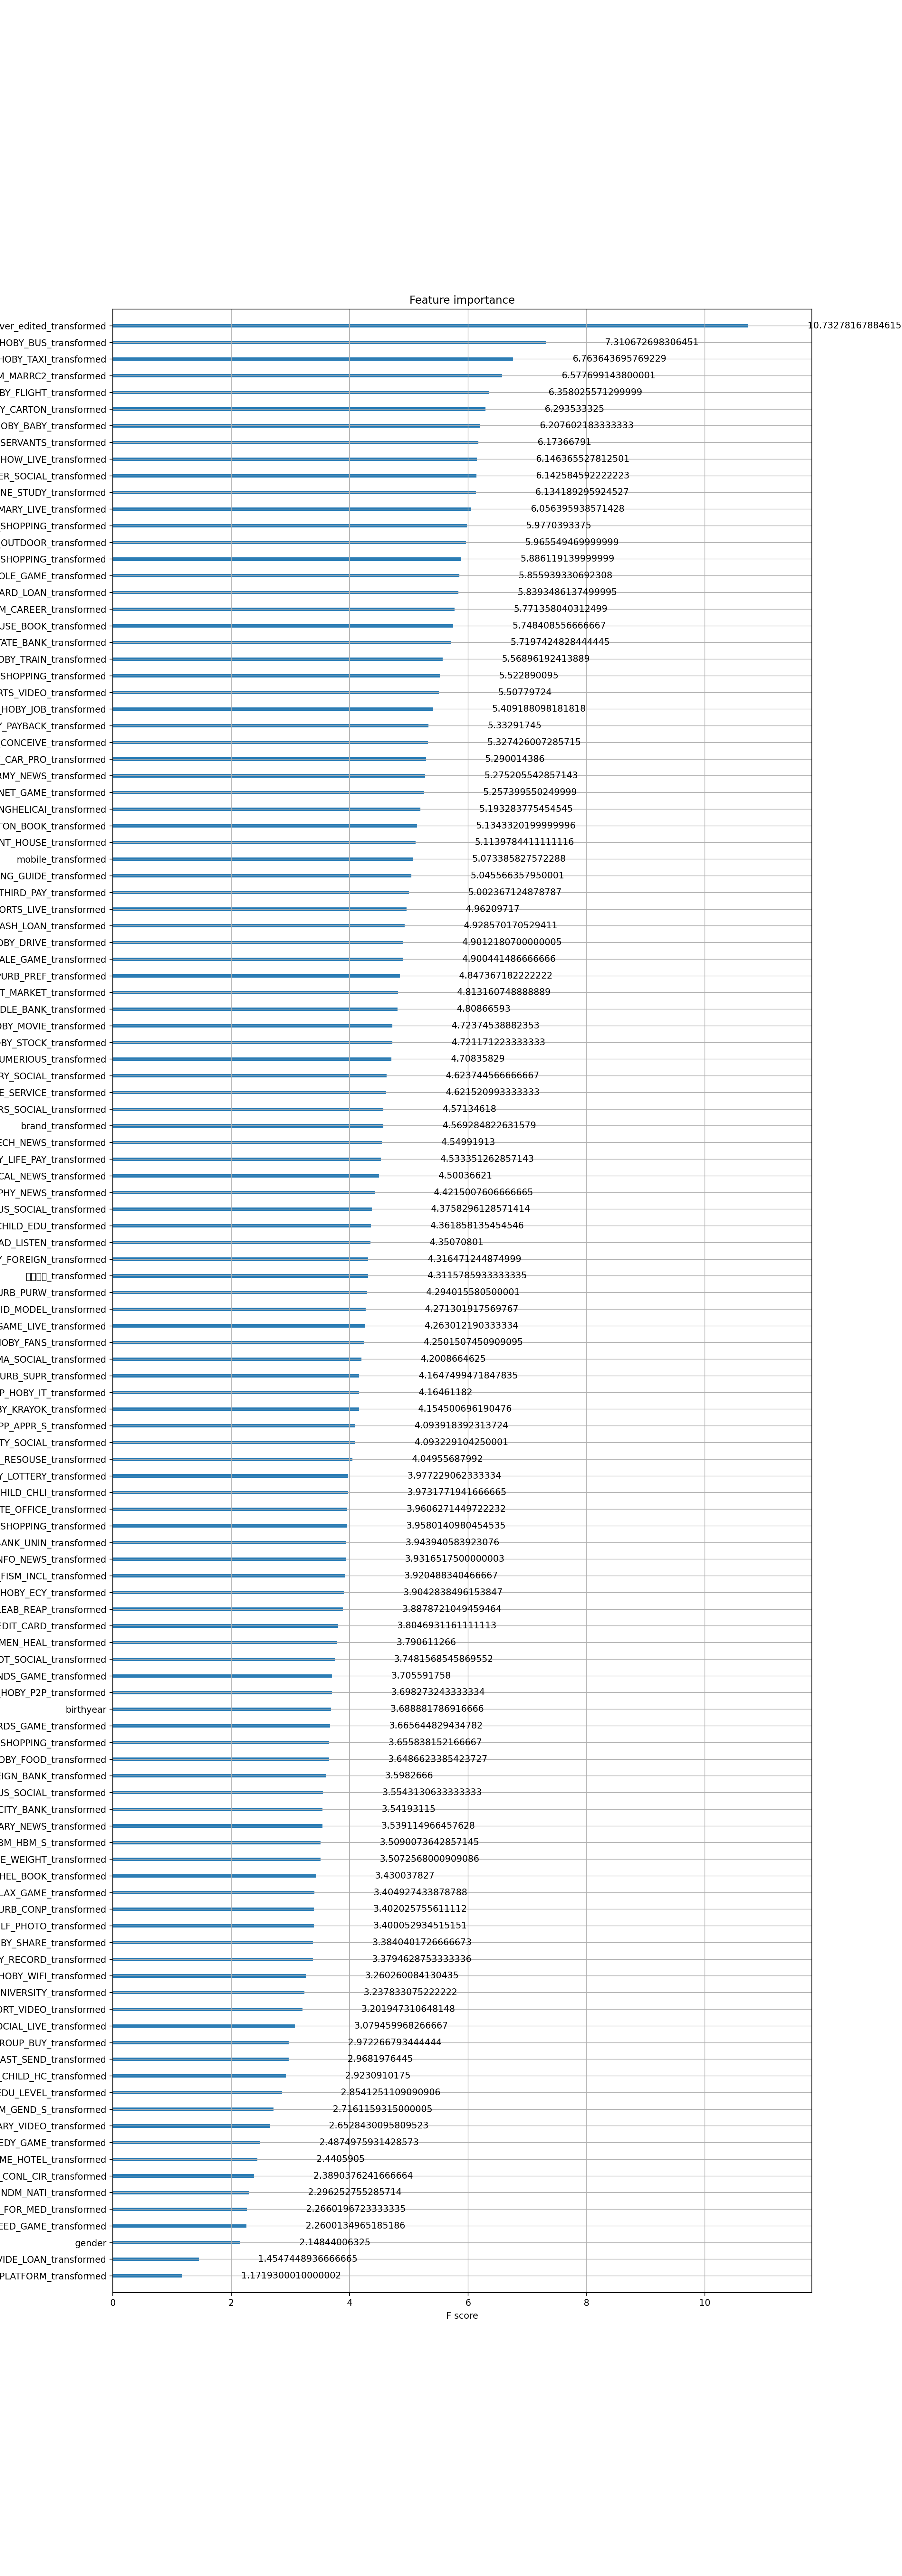

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [152]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (14, 40)
plot_importance(model,importance_type='gain')

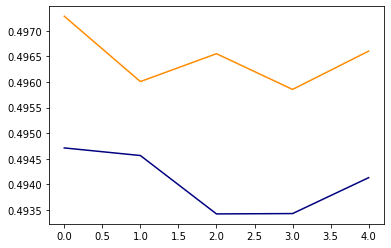

In [87]:
plt.plot(r0, color='navy')
plt.plot(r1, color='darkorange')

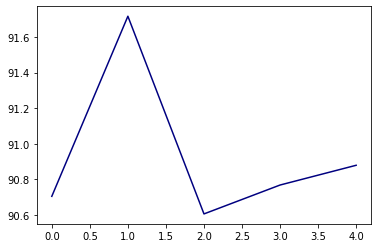

In [88]:
plt.plot(m0, color='navy')
#plt.plot(m1, color='darkorange')

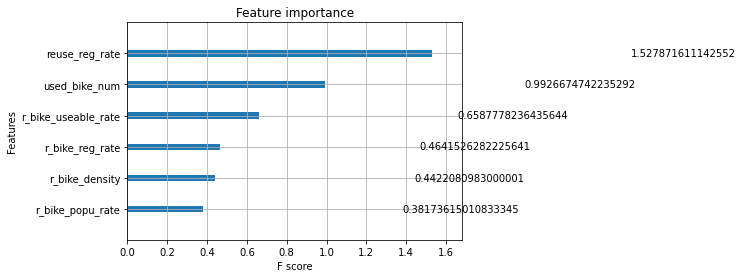

In [110]:
plot_importance(model,  importance_type='gain')
plt.show()

In [94]:
pd.DataFrame({'pred':pred, 'ans':test[col_ans]})

,pred,ans
507,4.118618,3.617007
525,1.980674,1.234337
548,2.731241,2.583333
600,2.389274,2.411894
626,2.870491,1.744343
652,3.378024,2.517389
761,4.893022,6.445691
781,3.098419,3.513205
1110,4.119232,5.940649
1140,4.296308,2.712168


In [7]:
df1=pd.read_csv('197_user_info.csv')
df1.shape

ParserError: Error tokenizing data. C error: Expected 2 fields in line 17, saw 5


In [153]:
1

1